## Setting Up Your Python Environment

In [1]:
# # %%capture
# # # Install PyTorch with CUDA
# !pip install torch torchvision torchaudio

# # # Install additional dependencies
# !pip install datasets matplotlib pandas pillow timm torcheval torchtnt==0.2.0 tqdm

# # # Install utility packages
# !pip install cjm_pandas_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

## Importing the Required Dependencies

In [1]:
# Import Python Standard Library dependencies
from copy import copy
import datetime
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random
import urllib.request

# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img, get_img_files
from cjm_psl_utils.core import download_file, file_extract
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor
from cjm_torchvision_tfms.core import ResizeMax, PadSquare

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import pandas module for data manipulation
import pandas as pd

# Do not truncate the contents of cells and display all rows and columns
pd.set_option('max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

# Import PIL for image manipulation
from PIL import Image

# Import timm library
import timm

# Import PyTorch dependencies
import torch
import torch.nn as nn
from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torch.utils.data import Dataset, DataLoader

import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

from torchtnt.utils import get_module_summary
from torcheval.metrics import MulticlassAccuracy

# Import tqdm for progress bar
from tqdm.auto import tqdm

## Setting Up the Project

### Setting a Random Number Seed

In [2]:
# Set the seed for generating random numbers in PyTorch, NumPy, and Python's random module.
seed = 1234
set_seed(seed)

### Setting the Device and Data Type

In [3]:
device = get_torch_device()
dtype = torch.float32
device, dtype

('cpu', torch.float32)

### Setting the Directory Paths

In [16]:
# # The name for the project
project_name = f"checkpoint"

# # The path for the project folder
project_dir = Path(f"../{project_name}/")

# # Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

# Define path to store datasets
dataset_dir = Path("../data")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# Define path to store archive files
archive_dir = Path('../Archive')
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Project Directory:": project_dir,
    "Dataset Directory:": dataset_dir,
    "Archive Directory:": archive_dir
}).to_frame().style.hide(axis='columns')

## Loading and Exploring the Dataset

### Setting the Dataset Path

### Downloading the Dataset

In [ ]:
def download_from_google_drive(url, archive_path):
    import subprocess

    if not archive_path.exists():
        subprocess.run(['gdown', url, '--fuzzy', '-O', archive_path])
    else:
        print(f'Already download zip file')

def extract_file(archive_path, extract_path):
    from pathlib import Path
    import tarfile

    # 解压缩 .tar.gz 文件
    if archive_path.exists():
        with tarfile.open(archive_path, 'r:gz') as tar:
            tar.extractall(path=extract_path)
        print(f"Extracted to {extract_path}")

        # 删除压缩文件（可选）
        # archive_path.unlink()
    else:
        print(f"Failed to download {archive_path}")

In [17]:
if not Path(f'{dataset_dir}/train').exists():
  url = 'https://drive.google.com/file/d/1fx4Z6xl5b6r4UFkBrn5l0oPEIagZxQ5u/view'

  # archive_dir = 'hw1-data.tar.gz'
  archive_file = 'hw1-data.tar.gz'
  # archive_path = Path(f'./{archive_dir}')
  archive_path = Path(f'{archive_dir}/{archive_file}')

  extract_path = Path('../')
  # extract_path = dataset_dir
  
  print(f'archive_path: {archive_path}, ext: {extract_path}')

  download_from_google_drive(url, archive_path)

  extract_file(archive_path, extract_path)


archive_path: ../Archive/hw1-data.tar.gz, ext: ..


Downloading...
From (original): https://drive.google.com/uc?id=1fx4Z6xl5b6r4UFkBrn5l0oPEIagZxQ5u
From (redirected): https://drive.google.com/uc?id=1fx4Z6xl5b6r4UFkBrn5l0oPEIagZxQ5u&confirm=t&uuid=37e96541-0585-4784-89d7-b213432053d0
To: /mnt/c/Users/bhg08/Desktop/github_repo/visual_dl/lab1/Archive/hw1-data.tar.gz
100%|██████████| 6.84G/6.84G [03:27<00:00, 33.0MB/s]


Extracted to ..


### Get Image Folders

In [11]:
dataset_path = Path(f'../data/train')

img_folder_paths = [folder for folder in dataset_path.iterdir() if folder.is_dir()]
# Display the names of the folders using a Pandas DataFrame
pd.DataFrame({"Image Folder": [folder.name for folder in img_folder_paths]})

Image Folder
0             0
1             1
2            10
3            11
4            12
5            13
6            14
7            15
8            16
9            17
10           18
11           19
12            2
13           20
14           21
15           22
16           23
17           24
18           25
19           26
20           27
21           28
22           29
23            3
24           30
25           31
26           32
27           33
28           34
29           35
30           36
31           37
32           38
33           39
34            4
35           40
36           41
37           42
38           43
39           44
40           45
41           46
42           47
43           48
44           49
45            5
46           50
47           51
48           52
49           53
50           54
51           55
52           56
53           57
54           58
55           59
56            6
57           60
58           61
59           62
60           63
61           64
62           65
63           66
64           67
65           68
66           69
67            7
68           70
69           71
70           72
71           73
72           74
73           75
74           76
75           77
76           78
77           79
78            8
79           80
80           81
81           82
82           83
83           84
84           85
85           86
86           87
87           88
88           89
89            9
90           90
91           91
92           92
93           93
94           94
95           95
96           96
97           97
98           98
99           99

In [12]:
val_dataset_path = Path(f'../data/val')

val_img_folder_paths = [folder for folder in val_dataset_path.iterdir() if folder.is_dir()]

pd.DataFrame({"Val image Folder": [folder.name for folder in val_img_folder_paths]})

Val image Folder
0                 0
1                 1
2                10
3                11
4                12
5                13
6                14
7                15
8                16
9                17
10               18
11               19
12                2
13               20
14               21
15               22
16               23
17               24
18               25
19               26
20               27
21               28
22               29
23                3
24               30
25               31
26               32
27               33
28               34
29               35
30               36
31               37
32               38
33               39
34                4
35               40
36               41
37               42
38               43
39               44
40               45
41               46
42               47
43               48
44               49
45                5
46               50
47               51
48               52
49               53
50               54
51               55
52               56
53               57
54               58
55               59
56                6
57               60
58               61
59               62
60               63
61               64
62               65
63               66
64               67
65               68
66               69
67                7
68               70
69               71
70               72
71               73
72               74
73               75
74               76
75               77
76               78
77               79
78                8
79               80
80               81
81               82
82               83
83               84
84               85
85               86
86               87
87               88
88               89
89                9
90               90
91               91
92               92
93               93
94               94
95               95
96               96
97               97
98               98
99               99

### Get Image File Paths

In [13]:
# Get a list of all image file paths from the image folders
class_file_paths = [get_img_files(folder) for folder in img_folder_paths]

# Get all image files in the 'img_dir' directory
img_paths = [
    file
    for folder in class_file_paths # Iterate through each image folder
    for file in folder # Get a list of image files in each image folder
]

# Print the number of image files
print(f"Number of Images: {len(img_paths)}")

# Display the first five entries using a Pandas DataFrame
pd.DataFrame(img_paths).head()

Number of Images: 20724


0
0  ../data/train/0/01bfe460-15c6-4a3c-b1f0-b4bd7479b82f.jpg
1  ../data/train/0/01d126c9-582b-4d62-9873-b1d448bd3950.jpg
2  ../data/train/0/08f8cef1-512d-4c65-bff9-16e070eb5287.jpg
3  ../data/train/0/0f0aed51-5899-4336-98cd-03fc0516e2cd.jpg
4  ../data/train/0/1125841e-38f6-47c7-babf-f31020e39e3a.jpg

In [14]:
# Get a list of all image file paths from the image folders
val_class_file_paths = [get_img_files(folder) for folder in val_img_folder_paths]

# Get all image files in the 'img_dir' directory
val_img_paths = [
    file
    for folder in val_class_file_paths # Iterate through each image folder
    for file in folder # Get a list of image files in each image folder
]

# Print the number of image files
print(f"Number of Images: {len(val_img_paths)}")

# Display the first five entries using a Pandas DataFrame
pd.DataFrame(val_img_paths).head()

Number of Images: 300


0
0  ../data/val/0/41fd7669-54ae-4536-a59b-c22353852147.jpg
1  ../data/val/0/5d00fb5a-b428-4e2a-91d9-d82e07c368f0.jpg
2  ../data/val/0/afb07d34-dce4-4583-a456-b2e5852d57f3.jpg
3  ../data/val/1/31f20004-c9f4-4894-82e9-68a6ff20b453.jpg
4  ../data/val/1/6fcb3798-455f-48d5-9ad0-691b4f34a8b2.jpg

### Inspecting the Class Distribution

#### Get image classes

In [15]:
# Get the number of samples for each image class
class_counts_dict = {folder[0].parent.name:len(folder) for folder in class_file_paths}

# Get a list of unique labels
class_names = list(class_counts_dict.keys())
print(class_names)

# Display the labels and the corresponding number of samples using a Pandas DataFrame
class_counts = pd.DataFrame.from_dict({'Count':class_counts_dict})
class_counts

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']


Count
0      37
1     129
10    235
11    450
12    196
13    181
14    194
15    324
16    283
17     45
18     54
19    450
2     171
20    120
21    105
22    322
23    450
24    116
25     82
26     99
27    450
28     85
29    135
3     450
30     89
31     99
32    450
33     36
34     35
35     38
36    450
37    405
38    391
39     71
4      74
40    198
41    270
42    450
43    450
44    350
45     86
46    251
47    194
48    224
49    234
5     314
50     85
51    450
52    450
53     88
54     79
55    126
56     64
57     87
58    450
59    290
6     128
60     20
61    174
62    113
63    132
64    144
65     55
66    109
67    101
68    271
69    177
7      85
70    352
71    386
72     91
73     72
74    450
75    360
76    450
77    145
78    208
79     66
8     123
80     79
81     85
82    450
83     35
84     65
85     65
86     63
87     99
88    450
89    146
9     291
90    125
91     92
92    450
93     47
94    111
95    250
96    220
97    450
98    134
99    314

#### Visualize the class distribution

In [ ]:
# Plot the distribution
class_counts.plot(kind='bar')
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), class_names)  # Set the x-axis tick labels
plt.xticks(rotation=75)  # Rotate x-axis labels
plt.gca().legend().set_visible(False)
plt.show()

### Visualizing Sample Images

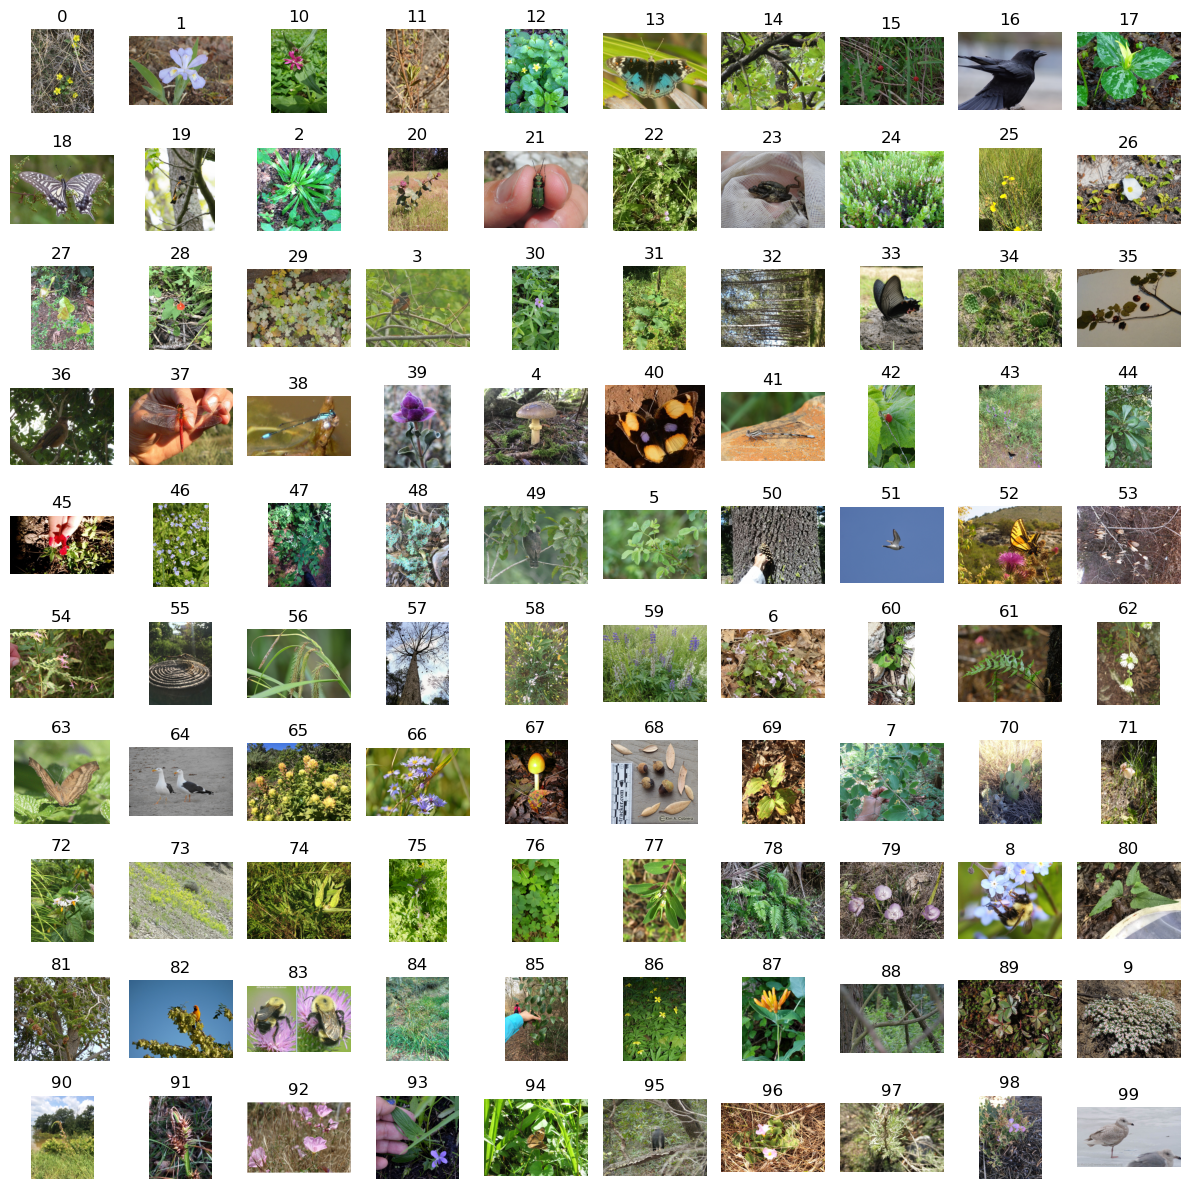

In [16]:
# Create a list to store the first image found for each class
sample_image_paths = [folder[0] for folder in class_file_paths]
sample_labels = [path.parent.stem for path in sample_image_paths]

# Calculate the number of rows and columns
grid_size = math.floor(math.sqrt(len(sample_image_paths)))
n_rows = grid_size+(1 if grid_size**2 < len(sample_image_paths) else 0)
n_cols = grid_size

# Create a figure for the grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,12))

for i, ax in enumerate(axs.flatten()):
    # If we have an image for this subplot
    if i < len(sample_image_paths) and sample_image_paths[i]:
        # Add the image to the subplot
        ax.imshow(np.array(Image.open(sample_image_paths[i])))
        # Set the title to the corresponding class name
        ax.set_title(sample_labels[i])
        # Remove the axis
        ax.axis('off')
    else:
        # If no image, hide the subplot
        ax.axis('off')

# Display the grid
plt.tight_layout()
plt.show()

## Selecting a Model

### Exploring Available Models

In [17]:
# pd.DataFrame(timm.list_models('resnet18*', pretrained=True))

### Inspecting the Model Configuration

In [18]:
# Import the resnet module
# from timm.models import resnet as model_family

# Define the base model variant to use
base_model = 'resnext101_32x8d'
version = "fb_swsl_ig1b_ft_in1k"

# Get the default configuration of the chosen model
model_cfg = timm.models.resnet.default_cfgs[base_model].default.to_dict()

# Show the default configuration values
pd.DataFrame.from_dict(model_cfg, orient='index')

# go wrong
# pd.DataFrame.from_dict(model_cfg)


0
url               https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth
hf_hub_id                                                                     timm/
custom_load                                                                   False
input_size                                                            (3, 224, 224)
fixed_input_size                                                              False
interpolation                                                              bilinear
crop_pct                                                                      0.875
crop_mode                                                                    center
mean                                                          (0.485, 0.456, 0.406)
std                                                           (0.229, 0.224, 0.225)
num_classes                                                                    1000
pool_size                                                                    (7, 7)
first_conv                                                                    conv1
classifier                                                                       fc
license                                                                bsd-3-clause
origin_url                                        https://github.com/pytorch/vision

### Retrieving Normalization Statistics

In [19]:
# Retrieve normalization statistics (mean and std) specific to the pretrained model
mean, std = model_cfg['mean'], model_cfg['std']
norm_stats = (mean, std)
norm_stats

((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

### Loading the Model

In [20]:
# Create a pretrained ResNet model with the number of output classes equal to the number of class names
# 'timm.create_model' function automatically downloads and initializes the pretrained weights
model = timm.create_model(f'{base_model}.{version}', pretrained=True, num_classes=len(class_names))

# Set the device and data type for the model
model = model.to(device=device, dtype=dtype)

# Add attributes to store the device and model name for later reference
model.device = device
model.name = f'{base_model}.{version}'

### Summarizing the Model

In [21]:
# Define the input to the model
test_inp = torch.randn(1, 3, 256, 256).to(device)

# Get a summary of the model as a Pandas DataFrame
summary_df = markdown_to_pandas(f"{get_module_summary(model, [test_inp])}")

# Filter the summary to only contain Conv2d layers and the model
summary_df = summary_df[(summary_df.index == 0) | (summary_df['Type'] == 'Conv2d')]

# Remove the column "Contains Uninitialized Parameters?"
summary_df.drop('Contains Uninitialized Parameters?', axis=1)

Type # Parameters # Trainable Parameters Size (bytes) Forward FLOPs  \
0    ResNet       86.9 M                 86.9 M        348 M        21.4 G   
1    Conv2d        9.4 K                  9.4 K       37.6 K         154 M   
7    Conv2d       16.4 K                 16.4 K       65.5 K        67.1 M   
10   Conv2d       18.4 K                 18.4 K       73.7 K        75.5 M   
15   Conv2d       65.5 K                 65.5 K        262 K         268 M   
19   Conv2d       16.4 K                 16.4 K       65.5 K        67.1 M   
22   Conv2d       65.5 K                 65.5 K        262 K         268 M   
25   Conv2d       18.4 K                 18.4 K       73.7 K        75.5 M   
30   Conv2d       65.5 K                 65.5 K        262 K         268 M   
34   Conv2d       65.5 K                 65.5 K        262 K         268 M   
37   Conv2d       18.4 K                 18.4 K       73.7 K        75.5 M   
42   Conv2d       65.5 K                 65.5 K        262 K         268 M   
47   Conv2d        131 K                  131 K        524 K         536 M   
50   Conv2d       73.7 K                 73.7 K        294 K        75.5 M   
55   Conv2d        262 K                  262 K        1.0 M         268 M   
59   Conv2d        131 K                  131 K        524 K         134 M   
62   Conv2d        262 K                  262 K        1.0 M         268 M   
65   Conv2d       73.7 K                 73.7 K        294 K        75.5 M   
70   Conv2d        262 K                  262 K        1.0 M         268 M   
74   Conv2d        262 K                  262 K        1.0 M         268 M   
77   Conv2d       73.7 K                 73.7 K        294 K        75.5 M   
82   Conv2d        262 K                  262 K        1.0 M         268 M   
86   Conv2d        262 K                  262 K        1.0 M         268 M   
89   Conv2d       73.7 K                 73.7 K        294 K        75.5 M   
94   Conv2d        262 K                  262 K        1.0 M         268 M   
99   Conv2d        524 K                  524 K        2.1 M         536 M   
102  Conv2d        294 K                  294 K        1.2 M        75.5 M   
107  Conv2d        1.0 M                  1.0 M        4.2 M         268 M   
111  Conv2d        524 K                  524 K        2.1 M         134 M   
114  Conv2d        1.0 M                  1.0 M        4.2 M         268 M   
117  Conv2d        294 K                  294 K        1.2 M        75.5 M   
122  Conv2d        1.0 M                  1.0 M        4.2 M         268 M   
126  Conv2d        1.0 M                  1.0 M        4.2 M         268 M   
129  Conv2d        294 K                  294 K        1.2 M        75.5 M   
134  Conv2d        1.0 M                  1.0 M        4.2 M         268 M   
138  Conv2d        1.0 M                  1.0 M        4.2 M         268 M   
141  Conv2d        294 K                  294 K        1.2 M        75.5 M   
146  Conv2d        1.0 M                  1.0 M        4.2 M         268 M   
150  Conv2d        1.0 M                  1.0 M        4.2 M         268 M   
153  Conv2d        294 K                  294 K        1.2 M        75.5 M   
158  Conv2d        1.0 M                  1.0 M        4.2 M         268 M   
162  Conv2d        1.0 M                  1.0 M        4.2 M         268 M   
165  Conv2d        294 K                  294 K        1.2 M        75.5 M   
170  Conv2d        1.0 M                  1.0 M        4.2 M         268 M   
174  Conv2d        1.0 M                  1.0 M        4.2 M         268 M   
177  Conv2d        294 K                  294 K        1.2 M        75.5 M   
182  Conv2d        1.0 M                  1.0 M        4.2 M         268 M   
186  Conv2d        1.0 M                  1.0 M        4.2 M         268 M   
189  Conv2d        294 K                  294 K        1.2 M        75.5 M   
194  Conv2d        1.0 M                  1.0 M        4.2 M         268 M   
198  Conv2d        1.0 M     

## Preparing the Data

### Training-Validation Split

In [22]:
# # Shuffle the image paths
# random.shuffle(img_paths)

# # Define the percentage of the images that should be used for training
train_pct = 1
val_pct = 0

# # Calculate the index at which to split the subset of image paths into training and validation sets
train_split = int(len(img_paths)*train_pct)
val_split = int(len(img_paths)*(train_pct+val_pct))

# # Split the subset of image paths into training and validation sets
train_paths = img_paths[:train_split]
val_paths = val_img_paths

# # Print the number of images in the training and validation sets
pd.Series({
    "Training Samples:": len(train_paths),
    "Validation Samples:": len(val_paths)
}).to_frame().style.hide(axis='columns')

### Data Augmentation

#### Set training image size

In [23]:
train_sz = 256

#### Initialize image transforms

In [24]:
# Set the fill color for padding images
fill = (0,0,0)

# Create a `ResizeMax` object
resize_max = ResizeMax(max_sz=train_sz)

# Create a `PadSquare` object
pad_square = PadSquare(shift=True, fill=fill)

# Create a TrivialAugmentWide object
trivial_aug = transforms.TrivialAugmentWide(fill=fill)

#### Test the transforms

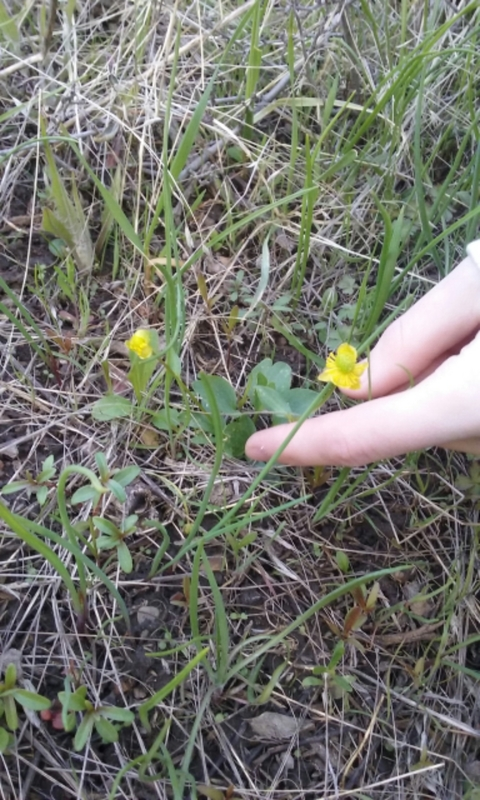

In [25]:
sample_img = Image.open(img_paths[11])
sample_img

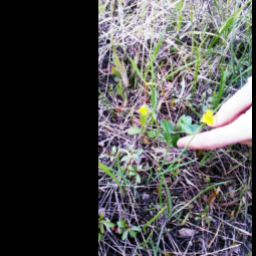

In [26]:
# Augment the image
augmented_img = trivial_aug(sample_img)

# Resize the image
resized_img = resize_max(augmented_img)

# Pad the image
padded_img = pad_square(resized_img)

# Ensure the padded image is the target size
resize = transforms.Resize([train_sz] * 2, antialias=True)
resized_padded_img = resize(padded_img)

# Display the annotated image
display(resized_padded_img)

pd.Series({
    "Source Image:": sample_img.size,
    "Resized Image:": resized_img.size,
    "Padded Image:": padded_img.size,
    "Resized Padded Image:": resized_padded_img.size,
}).to_frame().style.hide(axis='columns')

### Training Dataset Class

In [27]:
class ImageDataset(Dataset):
    """
    A PyTorch Dataset class for handling images.

    This class extends PyTorch's Dataset and is designed to work with image data.
    It supports loading images, and applying transformations.

    Attributes:
        img_paths (list): List of image file paths.
        class_to_idx (dict): Dictionary mapping class names to class indices.
        transforms (callable, optional): Transformations to be applied to the images.
    """

    def __init__(self, img_paths, class_to_idx, transforms=None):
        """
        Initializes the ImageDataset with image keys and other relevant information.

        Args:
            img_paths (list): List of image file paths.
            class_to_idx (dict): Dictionary mapping class names to class indices.
            transforms (callable, optional): Transformations to be applied to the images.
        """
        super(Dataset, self).__init__()

        self._img_paths = img_paths
        self._class_to_idx = class_to_idx
        self._transforms = transforms

    def __len__(self):
        """
        Returns the number of items in the dataset.

        Returns:
            int: Number of items in the dataset.
        """
        return len(self._img_paths)

    def __getitem__(self, index):
        """
        Retrieves an item from the dataset at the specified index.

        Args:
            index (int): Index of the item to retrieve.

        Returns:
            tuple: A tuple containing the image and its corresponding label.
        """
        img_path = self._img_paths[index]
        image, label = self._load_image(img_path)

        # Applying transformations if specified
        if self._transforms:
            image = self._transforms(image)

        return image, label

    def _load_image(self, img_path):
        """
        Loads an image from the provided image path.

        Args:
            img_path (string): Image path.
            Returns:
        tuple: A tuple containing the loaded image and its corresponding target data.
        """
        # Load the image from the file path
        image = Image.open(img_path).convert('RGB')

        return image, self._class_to_idx[img_path.parent.name]

### Image Transforms

In [28]:
# Compose transforms to resize and pad input images
resize_pad_tfm = transforms.Compose([
    resize_max,
    pad_square,
    transforms.Resize([train_sz] * 2, antialias=True)
])

# Compose transforms to sanitize bounding boxes and normalize input data
final_tfms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(*norm_stats),
])

# Define the transformations for training and validation datasets
# Note: Data augmentation is performed only on the training dataset
train_tfms = transforms.Compose([
    trivial_aug,
    resize_pad_tfm,
    final_tfms
])
valid_tfms = transforms.Compose([resize_pad_tfm, final_tfms])

### Initialize Datasets

In [29]:
# Create a mapping from class names to class indices
class_to_idx = {c: i for i, c in enumerate(class_names)}

# Instantiate the dataset using the defined transformations
train_dataset = ImageDataset(train_paths, class_to_idx, train_tfms)
valid_dataset = ImageDataset(val_paths, class_to_idx, valid_tfms)

# Print the number of samples in the training and validation datasets
pd.Series({
    'Training dataset size:': len(train_dataset),
    'Validation dataset size:': len(valid_dataset)}
).to_frame().style.hide(axis='columns')

### Inspect Samples

**Inspect training set sample**

Label: 0


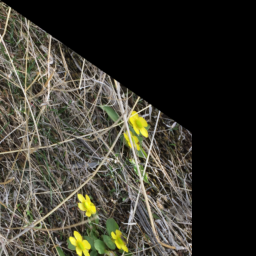

In [30]:
# Get the label for the first image in the training set
print(f"Label: {class_names[train_dataset[0][1]]}")

# Get the first image in the training set
TF.to_pil_image(denorm_img_tensor(train_dataset[0][0], *norm_stats))

**Inspect validation set sample**

Label: 0


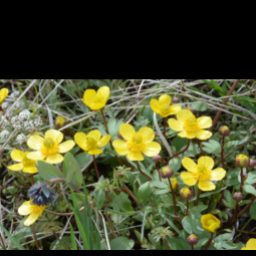

In [31]:
# Get the label for the first image in the validation set
print(f"Label: {class_names[valid_dataset[0][1]]}")

# Get the first image in the validation set
TF.to_pil_image(denorm_img_tensor(valid_dataset[0][0], *norm_stats))

### Training Batch Size

In [32]:
bs = 64

### Initialize DataLoaders

In [33]:
# Set the number of worker processes for loading data. This should be the number of CPUs available.
num_workers = multiprocessing.cpu_count()#//2

# Define parameters for DataLoader
data_loader_params = {
    'batch_size': bs,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    'persistent_workers': True,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    'pin_memory': 'cuda' in device,  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    'pin_memory_device': device if 'cuda' in device else '',  # Specifies the device where the data should be loaded. Commonly set to use the GPU.
}

# Create DataLoader for training data. Data is shuffled for every epoch.
train_dataloader = DataLoader(train_dataset, **data_loader_params, shuffle=True)

# Create DataLoader for validation data. Shuffling is not necessary for validation data.
valid_dataloader = DataLoader(valid_dataset, **data_loader_params)

# Print the number of batches in the training and validation DataLoaders
print(f'Number of batches in train DataLoader: {len(train_dataloader)}')
print(f'Number of batches in validation DataLoader: {len(valid_dataloader)}')

Number of batches in train DataLoader: 324
Number of batches in validation DataLoader: 5


## Fine-tuning the Model

### Define the Training Loop

In [34]:
# Function to run a single training/validation epoch
def run_epoch(model, dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch_id, is_training):
    # Set model to training mode if 'is_training' is True, else set to evaluation mode
    model.train() if is_training else model.eval()

    # Reset the performance metric
    metric.reset()
    # Initialize the average loss for the current epoch
    epoch_loss = 0
    # Initialize progress bar with total number of batches in the dataloader
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")

    # Iterate over data batches
    for batch_id, (inputs, targets) in enumerate(dataloader):
        # Move inputs and targets to the specified device (e.g., GPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Enables gradient calculation if 'is_training' is True
        with torch.set_grad_enabled(is_training):
            # Automatic Mixed Precision (AMP) context manager for improved performance
            with autocast(torch.device(device).type):
                outputs = model(inputs) # Forward pass
                loss = torch.nn.functional.cross_entropy(outputs, targets) # Compute loss

        # Update the performance metric
        metric.update(outputs.detach().cpu(), targets.detach().cpu())

        # If in training mode
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()

            optimizer.zero_grad()

        loss_item = loss.item()
        epoch_loss += loss_item
        # Update progress bar
        progress_bar.set_postfix(accuracy=metric.compute().item(),
                                 loss=loss_item,
                                 avg_loss=epoch_loss/(batch_id+1),
                                 lr=lr_scheduler.get_last_lr()[0] if is_training else "")
        progress_bar.update()

        # If loss is NaN or infinity, stop training
        if is_training:
            stop_training_message = f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."
            assert not math.isnan(loss_item) and math.isfinite(loss_item), stop_training_message

    progress_bar.close()
    return epoch_loss / (batch_id + 1)

In [35]:
# Main training loop
def train_loop(model, train_dataloader, valid_dataloader, optimizer, metric, lr_scheduler, device, epochs, checkpoint_path, use_scaler=False):
    # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
    scaler = GradScaler() if device.type == 'cuda' and use_scaler else None
    best_loss = float('inf')

    # Iterate over each epoch
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run training epoch and compute training loss
        train_loss = run_epoch(model, train_dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch, is_training=True)
        # Run validation epoch and compute validation loss
        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, metric, None, device, scaler, epoch, is_training=False)

        # If current validation loss is lower than the best one so far, save model and update best loss
        if valid_loss < best_loss:
            best_loss = valid_loss
            metric_value = metric.compute().item()
            torch.save(model.state_dict(), checkpoint_path)

            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'metric_value': metric_value,
                'learning_rate': lr_scheduler.get_last_lr()[0],
                'model_architecture': model.name
            }

            # Save best_loss and metric_value in a JSON file
            with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
                json.dump(training_metadata, f)

    # If the device is a GPU, empty the cache
    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()

### Set the Model Checkpoint Path

In [36]:
# Generate timestamp for the training session (Year-Month-Day_Hour_Minute_Second)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Create a directory to store the checkpoints if it does not already exist
checkpoint_dir = Path(project_dir/f"{timestamp}")

# Create the checkpoint directory if it does not already exist
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# The model checkpoint path
checkpoint_path = checkpoint_dir/f"{model.name}.pth"

print(checkpoint_path)

checkpoint/2025-03-18_11-46-34/resnext101_32x8d.fb_swsl_ig1b_ft_in1k.pth


### Saving the Class Labels

In [37]:
# Save class labels
class_labels = {"classes": list(class_names)}

# Set file path
class_labels_path = checkpoint_dir/f"{dataset_name}-classes.json"

# Save class labels in JSON format
with open(class_labels_path, "w") as write_file:
    json.dump(class_labels, write_file)

print(class_labels_path)

checkpoint/2025-03-18_11-46-34/lab1-classes.json


### Configure the Training Parameters

In [38]:
# Learning rate for the model
lr = 1e-2

# Number of training epochs
epochs = 80

# AdamW optimizer; includes weight decay for regularization
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-4)

# Learning rate scheduler; adjusts the learning rate during training
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                            max_lr=lr,
                            total_steps=epochs*len(train_dataloader))

# Performance metric: Multiclass Accuracy
metric = MulticlassAccuracy()

### Train the Model

In [39]:
train_loop(model=model,
           train_dataloader=train_dataloader,
           valid_dataloader=valid_dataloader,
           optimizer=optimizer,
           metric=metric,
           lr_scheduler=lr_scheduler,
           device=torch.device(device),
           epochs=epochs,
           checkpoint_path=checkpoint_path,
           use_scaler=True)

Epochs:   0%|          | 0/80 [00:00<?, ?it/s]

Train:   0%|          | 0/324 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Making Predictions with the Model

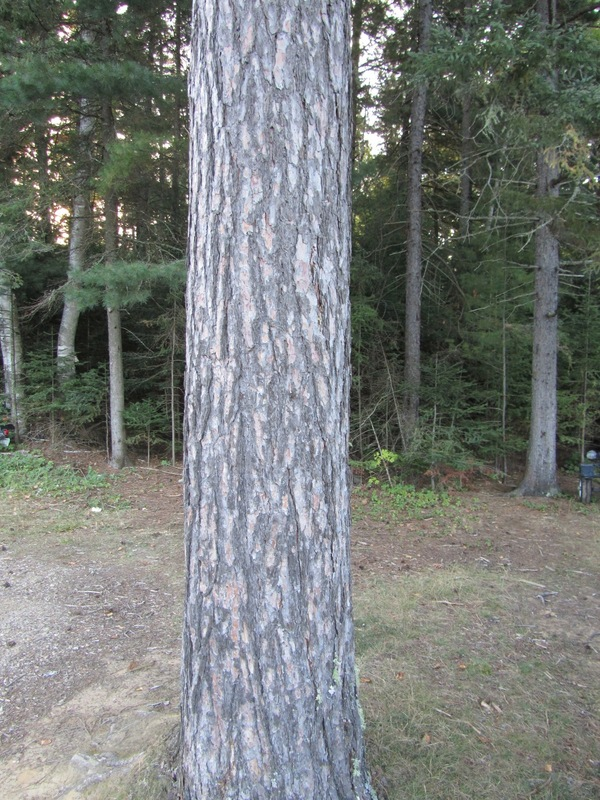

Predicted Class: 32


Confidence Score
32           99.95%
21            0.00%
61            0.00%
66            0.00%
4             0.00%
19            0.00%
57            0.04%
48            0.00%
22            0.00%
18            0.00%
69            0.00%
96            0.00%
35            0.00%
89            0.00%
67            0.00%
58            0.00%
12            0.00%
33            0.00%
13            0.00%
81            0.00%
85            0.00%
17            0.00%
62            0.00%
70            0.00%
24            0.00%
30            0.00%
0             0.00%
39            0.00%
20            0.00%
29            0.00%
5             0.00%
92            0.00%
14            0.00%
95            0.00%
31            0.00%
40            0.00%
94            0.00%
27            0.00%
93            0.00%
10            0.00%
55            0.00%
74            0.00%
53            0.00%
16            0.00%
88            0.00%
98            0.00%
72            0.00%
28            0.00%
87            0.00%
41            0.00%
97            0.00%
11            0.00%
63            0.00%
43            0.00%
49            0.00%
44            0.01%
77            0.00%
68            0.00%
26            0.00%
36            0.00%
8             0.00%
54            0.00%
2             0.00%
64            0.00%
71            0.00%
73            0.00%
9             0.00%
1             0.00%
82            0.00%
46            0.00%
15            0.00%
99            0.00%
45            0.00%
3             0.00%
47            0.00%
91            0.00%
50            0.00%
76            0.00%
51            0.00%
37            0.00%
52            0.00%
42            0.00%
23            0.00%
75            0.00%
34            0.00%
38            0.00%
25            0.00%
80            0.00%
83            0.00%
84            0.00%
60            0.00%
65            0.00%
59            0.00%
86            0.00%
6             0.00%
79            0.00%
90            0.00%
56            0.00%
78            0.00%
7             0.00%

In [ ]:
# Choose an item from the validation set
test_file = val_paths[0]

# Open the test file
test_img = Image.open(test_file).convert('RGB')

# Set the minimum input dimension for inference
input_img = resize_img(test_img, target_sz=train_sz, divisor=1)

# Convert the image to a normalized tensor and move it to the device
img_tensor = pil_to_tensor(input_img, *norm_stats).to(device=device)

# Make a prediction with the model
with torch.no_grad():
    pred = model(img_tensor)

# Scale the model predictions to add up to 1
pred_scores = torch.softmax(pred, dim=1)

# Get the highest confidence score
confidence_score = pred_scores.max()

# Get the class index with the highest confidence score and convert it to the class name
pred_class = class_names[torch.argmax(pred_scores)]

# Display the image
display(test_img)

print(f"Predicted Class: {pred_class}")

# Print the prediction data as a Pandas DataFrame for easy formatting
confidence_score_df = pd.DataFrame({
    'Confidence Score':{
        name:f'{score*100:.2f}%' for name, score in zip(class_names, pred_scores.cpu().numpy()[0])
    }
})
confidence_score_df

### Testing the Model on New Data

In [ ]:
def takeout_test_img(test_data_dir_path):
  # Get all image files in the 'img_dir' directory

  # # 設定測試數據集的路徑
  # test_data_dir_path = Path(f'../data/test')

  # 取出所有圖片文件
  image_paths = list(test_data_dir_path.glob('**/*.*'))  # 這裡使用通配符來匹配所有文件

  # 過濾出圖片文件（假設圖片文件的擴展名為 jpg, jpeg, png 等）
  image_paths = [path for path in image_paths if path.suffix.lower() in ['.jpg', '.jpeg', '.png']]

  # # 只保留圖片文件的名字
  # image_names = [path.name for path in image_paths]

  return image_paths

In [ ]:
model = timm.create_model(f'{base_model}.{version}', pretrained=True, num_classes=len(class_names))

model.load_state_dict(torch.load('/checkpoint/2025-03-11_02-23-57/resnext101_32x8d.fb_swsl_ig1b_ft_in1k.pth', weights_only=True))

model.eval()

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
def test(test_img):
  # Set the minimum input dimension for inference
  infer_sz = train_sz

  test_img = Image.open(test_img)

  inp_img = resize_img(test_img.copy(), infer_sz)

  # Convert the image to a normalized tensor and move it to the device
  img_tensor = pil_to_tensor(inp_img, *norm_stats).to(device=device)

  # Make a prediction with the model
  with torch.no_grad():
      pred = model(img_tensor)

  # Scale the model predictions to add up to 1
  pred_scores = torch.softmax(pred, dim=1)

  # Get the highest confidence score
  confidence_score = pred_scores.max()

  # Get the class index with the highest confidence score and convert it to the class name
  pred_class = class_names[torch.argmax(pred_scores)]

  return pred_class

In [ ]:
test_data_dir_path = Path('data/test')
test_data = takeout_test_img(test_data_dir_path)

pred_labels = []
for img in test_data:
  pred_labels.append(test(img))


In [ ]:
image_name = [img.stem for img in test_data]
# 創建 DataFrame
df = pd.DataFrame({"image_name": image_name, "pred_label": pred_labels})

print(df.head())

                             image_name pred_label
0  1fa7725f-b235-4c1b-8d06-6c33a1d9c7db         23
1  a268fad8-420c-4f0e-881c-ac85e079ee57         37
2  4644f9fc-7f25-44b7-97b5-c09a0efa4430          4
3  1c94f6dd-0ec1-4b50-a93b-da87b454baef          3
4  64b864f8-2df7-4def-bc37-cfe9af427ab6         46


In [ ]:
# 將 DataFrame 寫入 CSV 文件
tmp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
output_csv_path = Path(f'./prediction_{tmp}.csv')
df.to_csv(output_csv_path, index=False)

print(f"Predictions saved to {output_csv_path}")

Predictions saved to prediction_2025-03-11_09-15-30.csv


In [ ]:
from google.colab import files
files.download(output_csv_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
while True :
  pass